# Face Mask Detector

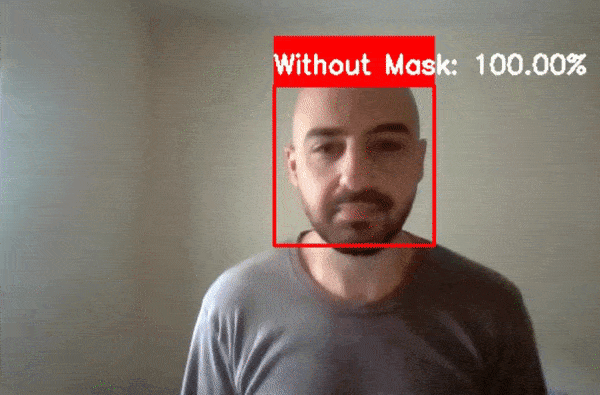

In [1]:
from IPython.display import Image
Image(open('C:/Users/tomer/Desktop/shortcompress.gif','rb').read())

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization.\
In this notebook, I'm going to build a real-time detector (via personal laptop webcam) which will be classified whether the person is wearing a mask or not. 

This notebook is divided into two parts:

- Part 1: Import, preprocess and build a few models using Keras library.
- Part 2: Chose the best model and test the result in LIVE via webcam, using OpenCV library.

The idea to do this project I took from [Kaggle](https://www.kaggle.com/search?q=mask+in%3Adatasets) and from [this guy](https://data-flair.training/blogs/face-mask-detection-with-python/).

## Data
The data contain 13,432 images of people with and without a mask. this dataset is balanced - 6,703 with mask and 6,729 without a mask.\
The data already divided into 3 separate datasets: train, validation and test.

#### Data sources:
I created the datasets (train, test and validation) by combining data from a few data sources: 

https://data-flair.training/blogs/download-face-mask-data/ - train and test setes.\
https://www.kaggle.com/dhruvmak/face-mask-detection - validation set.\
https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset - train, test and validation.

In this particular dataset, most of the images are have been processed, so I manually took only the original and non-processed images (the dataset is sorted so it's the images at the beginning):
https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset  - train, test and validation.


### Importing Libraries

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2

import tensorflow as tf
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Activation, Add, Dense, Input, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, ZeroPadding2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


np.random.seed(1234)
tf.random.set_seed(1234)

C:\Users\tomer\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Part 1

## Importing +  Preprocessing + Data Augmentation

In [2]:
# Train set
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(r"C:\Users\tomer\Desktop\train1", 
                                                    batch_size=32, 
                                                    target_size=(224, 224))

# Validation set
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(r"C:\Users\tomer\Desktop\validation1", 
                                                    batch_size=32, 
                                                    target_size=(224, 224))

# Test set
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(r"C:\Users\tomer\Desktop\test1", 
                                                    batch_size=32, 
                                                    target_size=(224, 224),shuffle=False)



Found 10600 images belonging to 2 classes.
Found 1546 images belonging to 2 classes.
Found 1286 images belonging to 2 classes.


Let's see some of the images.

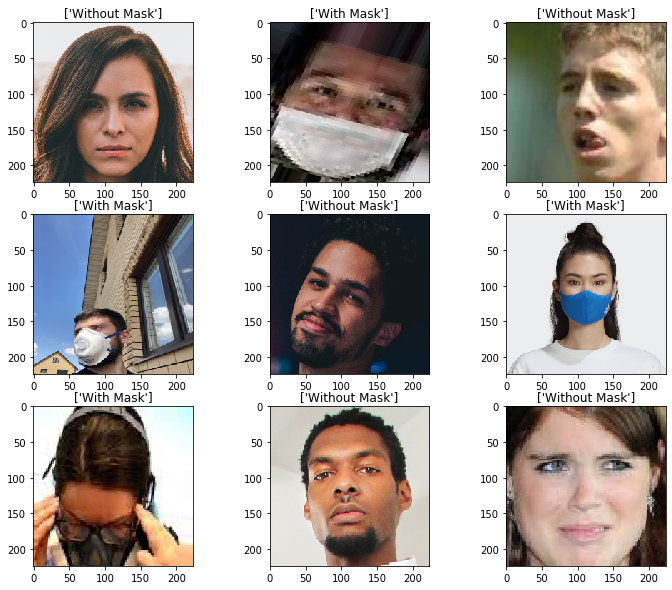

In [3]:
plt.figure(figsize=(12, 10))

x,y = validation_generator.next()
index = 0
for i in range(0,9):
    index += 1
    plt.subplot(3, 3, index)
    image_x = x[i,:,:]
    plt.imshow(image_x)
    plt.title(["With Mask" if y[i][0] == 1 else "Without Mask"])

### Create custom function for plot the model history

In [4]:
def plot_history(History,Metric = 'accuracy'):
    metric = History.history[Metric]
    val_metric = History.history['val_'+ str(Metric)]
    loss = History.history['loss']
    val_loss = History.history['val_loss']
    epochs = range(len(metric))

    plt.plot(epochs, metric, 'r--', label='Training ' + str(Metric))
    plt.plot(epochs, val_metric, 'b', label='Validation ' + str(Metric))
    plt.title('Training and validation '+ str(Metric))
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

### Create custom function for plot the confusion matrix

In [16]:
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, cbar=False)

## Models

### Build a simple convolutional neural network model

In [6]:
def conv_model(last_activation='softmax',n_class=2, n_neurons=500, input_shape=(224,224,3), loss="binary_crossentropy", metric='accuracy', learning_rate=1e-3):
    model = Sequential([
                        
        Conv2D(18, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(n_neurons),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.5),
        
        Dense(n_neurons),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.5),
        
        Dense(n_class, activation=last_activation)
    ])

    model.compile(optimizer= Adam(lr=learning_rate),
                  loss=loss,
                  metrics=[metric])
    return model

In [9]:
model1 = conv_model()
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 18)      504       
_________________________________________________________________
batch_normalization_8 (Batch (None, 224, 224, 18)      72        
_________________________________________________________________
activation_8 (Activation)    (None, 224, 224, 18)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 18)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      5216      
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 112, 112, 32)     

In [10]:
%%time

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=7, verbose=1)
mcp = ModelCheckpoint(filepath='conv_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)



steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history1 = model1.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=50,
                    validation_data = validation_generator,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Epoch 1/50
331/331 [==============================] - 260s 787ms/step - loss: 0.3242 - accuracy: 0.8889 - val_loss: 0.3106 - val_accuracy: 0.8704

Epoch 00001: val_loss improved from inf to 0.31057, saving model to conv_weights.h5
Epoch 2/50
331/331 [==============================] - 265s 801ms/step - loss: 0.1906 - accuracy: 0.9283 - val_loss: 0.2690 - val_accuracy: 0.7596

Epoch 00002: val_loss improved from 0.31057 to 0.26904, saving model to conv_weights.h5
Epoch 3/50
331/331 [==============================] - 267s 808ms/step - loss: 0.1584 - accuracy: 0.9396 - val_loss: 0.5094 - val_accuracy: 0.7497

Epoch 00003: val_loss did not improve from 0.26904
Epoch 4/50
331/331 [==============================] - 268s 811ms/step - loss: 0.1371 - accuracy: 0.9497 - val_loss: 0.9741 - val_accuracy: 0.5264

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 00004: val_loss did not improve from 0.26904
Epoch 5/50
331/331 [==============================] - 272

In [11]:
score = model1.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.023497091606259346
Test accuracy: 0.9836702942848206


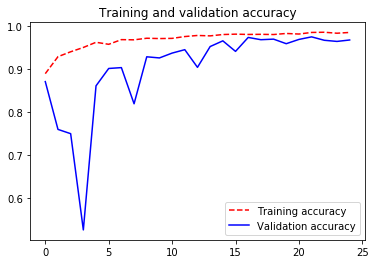

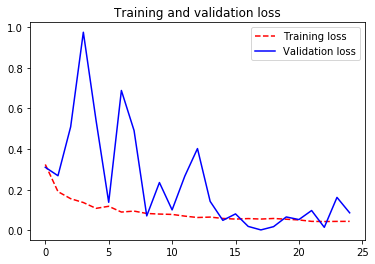

In [12]:
plot_history(history1)

[[612  18]
 [  3 653]] 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       630
           1       0.97      1.00      0.98       656

    accuracy                           0.98      1286
   macro avg       0.98      0.98      0.98      1286
weighted avg       0.98      0.98      0.98      1286
 



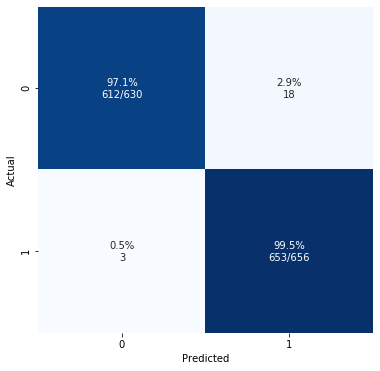

In [17]:
pred1 = model1.predict_generator(test_generator) > 0.5
pred1 =np.argmax(pred1,axis=1)
y_true= test_generator.classes

#Create the report and confusion matrix
cm = confusion_matrix(y_true, pred1)
print(cm,'\n')
print(classification_report(y_true, pred1),'\n')

plot_cm(y_true, pred1)

## Transfer Learning 

Keras Applications module provides a variety of built-in deep learning models that are made available alongside pre-trained weights on imagenet dataset. These models can be used for prediction, feature extraction, and fine-tuning.

[Here is a link](https://keras.io/api/applications/) for the full list of the models and additional details.

In this notebook, I will examine: Xception, MobileNet state of the art models that are available in Keras.
They both use depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution).

- Xception reference - https://arxiv.org/abs/1610.02357
- MobileNet reference - https://arxiv.org/abs/1704.04861

### Xception Model

Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions. It was developed by Google researchers. Google presented an interpretation of Inception modules in convolutional neural networks as being an intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution). Besides depthwise separable convolution, they use shortcuts between Convolution blocks as in ResNet architecture.

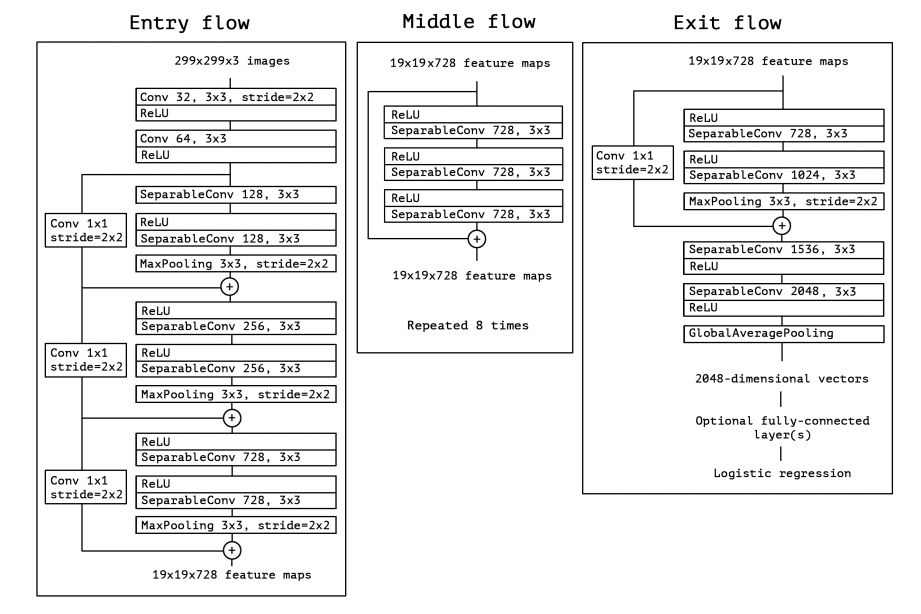

In [26]:
Image(open('C:/Users/tomer/Desktop/xception.jpg','rb').read())

In [14]:
# Transfer learning + adding custom layers on top
x_base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),weights="imagenet", include_top=False, classes=2)
x_avg = GlobalAveragePooling2D()(x_base_model.output)
x_dense = Dense(1024,activation='relu')(x_avg) 
x_output = Dense(2, activation="softmax")(x_dense)
model2 = keras.models.Model(inputs=x_base_model.input, outputs=x_output) 

# Only train the new layers, original layers will remain “frozen”.
for layer in x_base_model.layers:
    layer.trainable = False

# Compile the model 
model2.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [15]:
%%time

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='Xception.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)



steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history2 = model2.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=50,
                    validation_data = validation_generator,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Epoch 1/50
331/331 [==============================] - 509s 2s/step - loss: 0.1723 - accuracy: 0.9355 - val_loss: 0.3370 - val_accuracy: 0.9740

Epoch 00001: val_loss improved from inf to 0.33701, saving model to Xception.h5
Epoch 2/50
331/331 [==============================] - 535s 2s/step - loss: 0.1067 - accuracy: 0.9597 - val_loss: 0.0507 - val_accuracy: 0.9894

Epoch 00002: val_loss improved from 0.33701 to 0.05071, saving model to Xception.h5
Epoch 3/50
331/331 [==============================] - 534s 2s/step - loss: 0.0937 - accuracy: 0.9678 - val_loss: 0.0941 - val_accuracy: 0.9908

Epoch 00003: val_loss did not improve from 0.05071
Epoch 4/50
331/331 [==============================] - 534s 2s/step - loss: 0.0827 - accuracy: 0.9715 - val_loss: 0.1248 - val_accuracy: 0.9861

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 00004: val_loss did not improve from 0.05071
Epoch 5/50
331/331 [==============================] - 534s 2s/step - loss: 0.

In [18]:
score = model2.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9027822613716125
Test accuracy: 0.9891135096549988


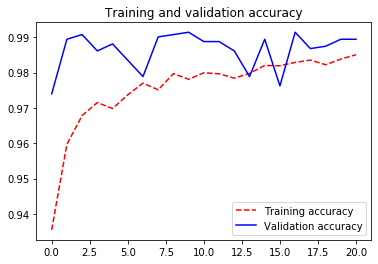

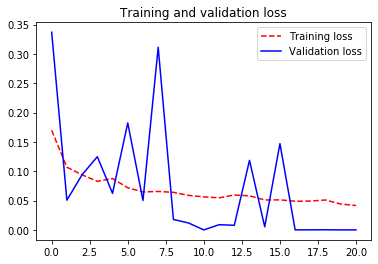

In [19]:
plot_history(history2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       630
           1       0.99      0.99      0.99       656

    accuracy                           0.99      1286
   macro avg       0.99      0.99      0.99      1286
weighted avg       0.99      0.99      0.99      1286
 

[[624   6]
 [  8 648]] 



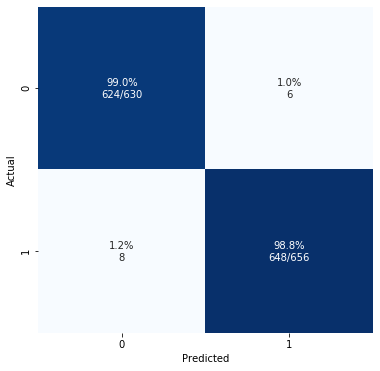

In [20]:
pred2 = model2.predict_generator(test_generator) > 0.5
pred2=np.argmax(pred2,axis=1)
y_true= test_generator.classes

print(classification_report(y_true, pred2),'\n')
cm = confusion_matrix(y_true, pred2)
print(cm,'\n')
plot_cm(y_true, pred2)

### MobileNet Model

MobileNet is a type of convolutional neural network designed for mobile and embedded vision applications. It based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks that can have low latency for mobile and embedded devices. Like Xception It was developed by Google researchers as well. Their purpose was to increase the efficiency of the network by decreasing the number of parameters by not compromising on performance.

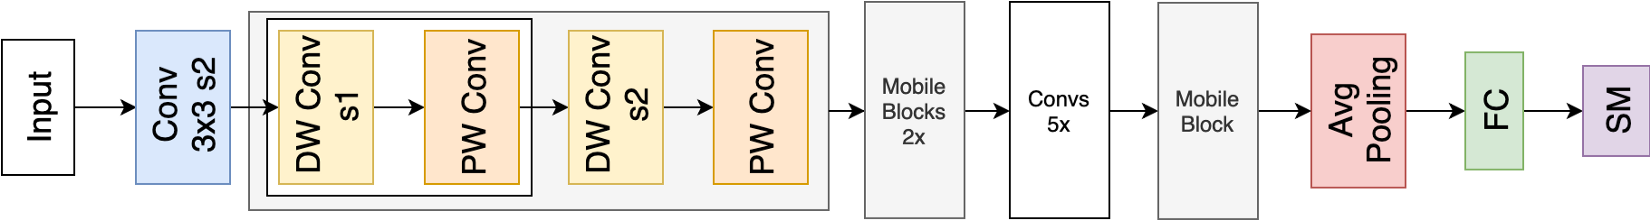

In [31]:
Image(open(r'C:/Users/tomer/Desktop/mobilenet.png','rb').read())

In [62]:
# Transfer learning + adding custom layers on top
mob_base_model = keras.applications.MobileNet(input_shape=(224, 224, 3),weights="imagenet", include_top=False, classes=2)
mob_avg = GlobalAveragePooling2D()(mob_base_model.output)
mob_dense = Dense(1024,activation='relu')(mob_avg) 
mob_output = Dense(2, activation="softmax")(mob_dense)
model3 = keras.models.Model(inputs=mob_base_model.input, outputs=mob_output) 

# Only train the new layers, original layers will remain “frozen”.
for layer in mob_base_model.layers:
    layer.trainable = False

# Compile the model 
model3.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [63]:
%%time

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='MobileNet.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)



steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history3 = model3.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=50,
                    validation_data = validation_generator,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Epoch 1/50
331/331 [==============================] - 262s 792ms/step - loss: 0.1330 - accuracy: 0.9555 - val_loss: 0.3354 - val_accuracy: 0.9434

Epoch 00001: val_loss improved from inf to 0.33538, saving model to MobileNet.h5
Epoch 2/50
331/331 [==============================] - 249s 752ms/step - loss: 0.0697 - accuracy: 0.9748 - val_loss: 0.0194 - val_accuracy: 0.9782

Epoch 00002: val_loss improved from 0.33538 to 0.01942, saving model to MobileNet.h5
Epoch 3/50
331/331 [==============================] - 249s 753ms/step - loss: 0.0603 - accuracy: 0.9785 - val_loss: 0.2962 - val_accuracy: 0.9326

Epoch 00003: val_loss did not improve from 0.01942
Epoch 4/50
331/331 [==============================] - 247s 745ms/step - loss: 0.0639 - accuracy: 0.9762 - val_loss: 0.0055 - val_accuracy: 0.9775

Epoch 00004: val_loss improved from 0.01942 to 0.00552, saving model to MobileNet.h5
Epoch 5/50
331/331 [==============================] - 256s 772ms/step - loss: 0.0514 - accuracy: 0.9815 - val_

In [64]:
score = model3.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.002824898110702634
Test accuracy: 0.9891135096549988


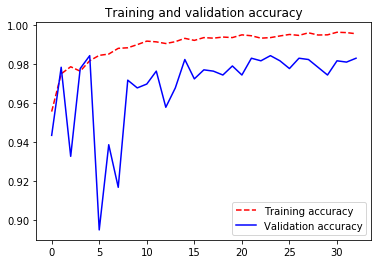

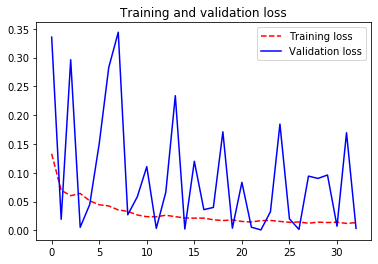

In [65]:
plot_history(history3)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       630
           1       0.98      1.00      0.99       656

    accuracy                           0.99      1286
   macro avg       0.99      0.99      0.99      1286
weighted avg       0.99      0.99      0.99      1286
 

[[619  11]
 [  3 653]] 



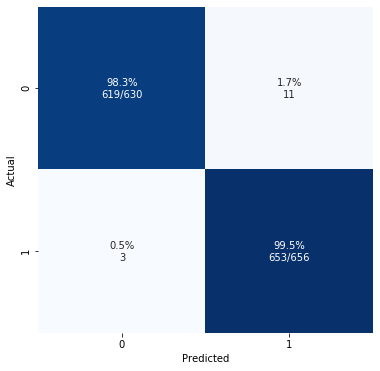

In [66]:
pred3 = model3.predict_generator(test_generator) > 0.5
pred3=np.argmax(pred3,axis=1)
y_true= test_generator.classes

print(classification_report(y_true, pred3),'\n')
cm = confusion_matrix(y_true, pred3)
print(cm,'\n')
plot_cm(y_true, pred3)

## Results 

**Custom Convolutional Model**  -  Accuracy: 98.36702% , Time: 1 hour and 52 minutes.\
**Xception Model** - Accuracy: 98.91135% , Time: 3 hours and 9 minutes.\
**MobileNet Model** -  Accuracy: 98.911309% , Time: 2 hours and 20 minutes.

First, it is a surprise that the simple model managed to reach such a high level of accuracy, almost the same as the others.\
second, it seems that all the models performed pretty much the same but the Custom Convolutional model was the quickest and Xception was the slowest (as expected).

For the next part, I'm taking the Xception model weights for the prediction. 

# Part 2

Now, let's check how our face mask classification model works on real life situation.
Using the OpenCV library and the built-in face detection model it has, we will open the personal webcam on the laptop and hopefully the built-in detection model will recognize our faces. Then, we will use the best classification model from the ones we tested earlier and will see if the system will recognize whether the person with or without a mask.

In [2]:
# load the best model weights
model= load_model("Xception.h5")

cap = cv2.VideoCapture(0) 
haarcascade = cv2.CascadeClassifier(r'C:\Users\tomer\Anaconda3\Library\etc\haarcascades\haarcascade_frontalface_default.xml')

while True:
    (rval, img) = cap.read()
    img = cv2.flip(img,1,1) #Flip to act as a mirror

    # detect MultiScale / faces 
    faces = haarcascade.detectMultiScale(img)
    
    # Draw rectangles around each face
    for (x, y, w, h) in faces:
              
        # Save just the rectangle faces in SubRecFaces
        face_img = img[y:y+h, x:x+w]
        face_img_sized = cv2.resize(face_img,(224,224))
        normalized = face_img_sized/255.0
        reshaped = np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        
        # Takes the face image and do a prediction 
        (mask, withoutMask) = model.predict(reshaped)[0]
        label = "Mask" if mask > withoutMask else "Without Mask"
        
        # Green frame for "With Mask" and red for "Without Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
        # Using the predict probabilities 
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)  
        
        # Rectangles frame setting
        cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color,-1)
        cv2.putText(img, label, (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
        
    cv2.imshow('Face Mask Detector', img)
    key = cv2.waitKey(2)

    # press 'q' key for break the loop and end the program
    if key == ord('q'): 
        break

# Stop video
cap.release()
        
cv2.destroyAllWindows()